In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import pandas as pd

In [5]:
# loading the graph from the pkl file
G = pkl.load(open("network_graph.pkl", "rb"))
G = nx.Graph(G)

In [65]:
# load egonet features from pickle
egonet_features = pkl.load(open("egonet_features.pkl", "rb"))

# load score_edpl from pickle
scores_edpl = pkl.load(open("score_edpl.pkl", "rb"))

# load score_ewpl from pickle
scores_ewpl = pkl.load(open("score_ewpl.pkl", "rb"))

# load score_elwpl from pickle
scores_elwpl = pkl.load(open("score_elwpl.pkl", "rb"))

# load combined_scores from pickle
combined_scores = pkl.load(open("combined_scores.pkl", "rb"))

# load graph_deviance from pickle
graph_deviance = pkl.load(open("score_graph_deviance.pkl", "rb"))

# load label_mapping
label_mapping = pkl.load(open("label_mapping.pkl", "rb"))

In [66]:
temp = {}
temp["IP"] = list(combined_scores.keys())
temp["Outlier_score"] = list(combined_scores[key] for key in combined_scores.keys())
temp["Label"] = [label_mapping.get(ip, "Unknown") for ip in temp["IP"]]

combined_scores = pd.DataFrame(temp)

In [67]:
combined_scores.sort_values(by="Outlier_score", ascending=False, inplace=True)

In [68]:
combined_scores

,IP,Outlier_score,Label
1148,185.92.73.85,2.658524,Benign
2787,23.36.32.43,2.459180,Benign
9194,210.206.216.138,2.340506,Benign
22622,58.63.230.158,2.340506,Benign
22463,121.8.141.142,2.340506,Benign
...,...,...,...
3176,195.2.253.111,0.008583,Benign
3101,83.212.126.27,0.008583,Benign
2104,138.68.147.73,0.008583,Benign
4690,190.221.56.226,0.008583,Benign


In [69]:
from scipy.stats import mannwhitneyu

# Split into benign and attack
benign_scores = combined_scores[combined_scores["Label"] == "Benign"]["Outlier_score"]
attack_scores = combined_scores[combined_scores["Label"] != "Benign"]["Outlier_score"]

# Perform test
stat, p_value = mannwhitneyu(benign_scores, attack_scores, alternative='two-sided')

print(f"Mann-Whitney U stat: {stat:.3f}")
print(f"p-value: {p_value}")


Mann-Whitney U stat: 672.000
p-value: 1.0590513859504347e-08


#### p-value = $1.059*10^{-8} << 0.05$
This indicates that the two distributions are significantly different, and we can reject the null hypothesis that they are from the same distribution.

In [70]:
from sklearn.metrics import roc_auc_score, roc_curve

# Convert labels to binary
y_true = combined_scores["Label"].apply(lambda x: 1 if x != "Benign" else 0)
y_scores = combined_scores["Outlier_score"]

auc = roc_auc_score(y_true, y_scores)
print(f"AUC: {auc:.4f}")


AUC: 0.9978




#### AUC = 0.9978

- This model has an **AUC of 0.9978**, which is extremely close to perfect.
- This implies that **99.78% of the time**, an attack node has a higher outlier score than a benign node.

---

#### Interpretation

- Your anomaly scoring system is doing an excellent job at **ranking** nodes by likelihood of being an attack.
- Very few benign nodes are scoring higher than attack nodes — which is exactly what you want.

---

#### TL;DR

An AUC of 0.9978 = your outlier score is highly effective at detecting attacks by ranking them above benign traffic.


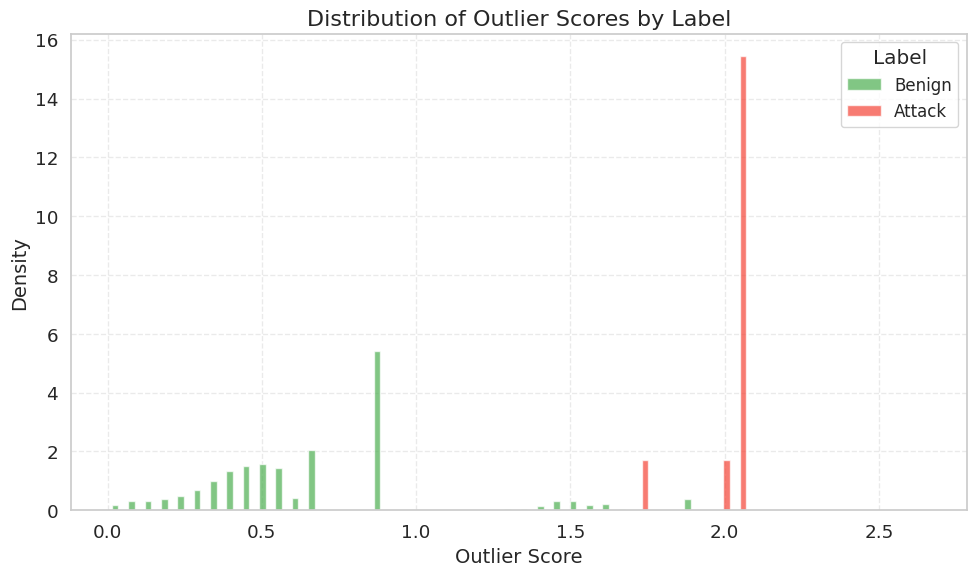

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid', font_scale=1.2)

# Figure size
plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(
    [combined_scores[combined_scores['Label'] == 'Benign']['Outlier_score'], 
     combined_scores[combined_scores['Label'] != 'Benign']['Outlier_score']],
    bins=50,
    label=['Benign', 'Attack'],
    color=['#4CAF50', '#F44336'],  # Green for benign, Red for attack
    alpha=0.7,
    density=True
)

# Customize axes
plt.xlabel('Outlier Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Outlier Scores by Label', fontsize=16)
plt.legend(title='Label', fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.4)

# Show plot
plt.show()


#### Observations
- Attack nodes are heavily concentrated in the higher outlier score range (~2.0), suggesting that your anomaly detection system assigns high scores to actual attacks — a good sign.

- Benign nodes mostly cluster around lower outlier scores (0.0–1.2), with a long tail but very few crossing into the high outlier score territory.

- There’s a clear separation between most benign and attack nodes, which supports the strong AUC value you previously observed (0.9978).

In [72]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming your DataFrame is named df
# Separate the data into two groups
benign_scores = combined_scores[combined_scores['Label'] == 'Benign']['Outlier_score']
ddos_scores = combined_scores[combined_scores['Label'] == 'DDoS attacks-LOIC-HTTP']['Outlier_score']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(benign_scores, ddos_scores)

# Print the result of the t-test
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Calculate Cohen's d for effect size
mean_benign = np.mean(benign_scores)
mean_ddos = np.mean(ddos_scores)
std_benign = np.std(benign_scores, ddof=1)
std_ddos = np.std(ddos_scores, ddof=1)

# Pooled standard deviation
pooled_std = np.sqrt(((len(benign_scores) - 1) * std_benign**2 + (len(ddos_scores) - 1) * std_ddos**2) / (len(benign_scores) + len(ddos_scores) - 2))

# Cohen's d
cohen_d = (mean_benign - mean_ddos) / pooled_std

# Print the effect size
print(f"Cohen's d (Effect Size): {cohen_d}")

# Interpretation
if p_value < 0.05:
    if abs(cohen_d) > 0.8:
        print("The difference is statistically significant and the effect size is large.")
    elif abs(cohen_d) > 0.5:
        print("The difference is statistically significant and the effect size is medium.")
    else:
        print("The difference is statistically significant but the effect size is small.")
else:
    print("No significant difference detected between the groups.")


T-statistic: -11.918265262634677
P-value: 1.1401615585267359e-32
Cohen's d (Effect Size): -3.5941969979869937
The difference is statistically significant and the effect size is large.
